**Step 0 - install and import dependencies**

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [35]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [112]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [226]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [227]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


In [228]:
df

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...
...,...,...
295,296,ค่ำนี้คุณเพื่อนอยากส้มตำ หมูเฮาเลยพากันลงมากิน...
296,297,ร้านสะอาดดี ตกแต่งสวยงาม มีที่จอดรถ ราคาเมนูต่...
297,298,เช้าๆ รีบๆ วิ่งมาเข่าห้องเรียนแทบไม่ทันแต่ต้อง...
298,299,ร้านนี้เป็นร้านกาแฟเล็กๆ ข้างๆ ร้านๆ Happy Man...


**Step 1 - document embedding and dimension reduction**

In [229]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993826,  0.01941082,  0.03787042, ..., -0.03488847,
         0.06299516,  0.04635992],
       [ 0.00634244,  0.00814592,  0.03071937, ..., -0.01478722,
        -0.03080932, -0.03316409],
       [ 0.06336871, -0.02027143, -0.05077004, ..., -0.06530776,
        -0.00953   , -0.03439991],
       ...,
       [ 0.08775926,  0.03609738,  0.01263058, ..., -0.03102781,
        -0.03361676,  0.0192887 ],
       [ 0.05691194,  0.05381689, -0.03995756, ..., -0.06598807,
        -0.05390474, -0.01037728],
       [ 0.07770476,  0.05080628,  0.02680678, ..., -0.00614126,
        -0.01313565,  0.02236263]], dtype=float32)

In [230]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

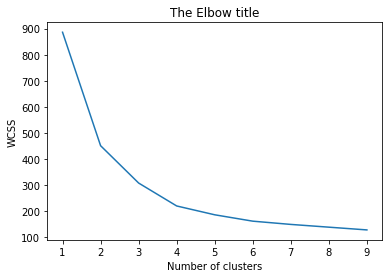

In [231]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [281]:
#run kmeans with no. of clusters you see fit the most

k = 5

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [282]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [283]:
df_kmeans

,KMeans ID,texts
0,0,5 เป็นร้านที่สะดุดตาที่สุดบนถนนจรัญ เลยก็...
1,1,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
2,2,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
3,3,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
4,4,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...


In [284]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [285]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [286]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [287]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [288]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [289]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [298]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน','ร้านอาหาร','อร่อย','อาหาร','ทาน','ราคา','สวัสดี','กิน','เพื่อน','กก','รีวิว','ผม','แวะ','บ้าน','คน','เมนู']
screening_words = stopwords + removed_words

new_words = {"สตารบัก"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words and len(word) > 1:
      merged.append(word)
  return merged

In [299]:
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [300]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เป็นร้านที่สะดุดตาที่สุดบนถนนจรัญเลยก็ว่าได้สถ...,"[สะดุดตา, ถนน, จรัญ, สถาน, ที่ตั้ง, ปากซอย, สุ...","[(ชอบ, 7), (ร้านกาแฟ, 6), (คาเฟ่, 5), (กาแฟ, 5..."
1,1,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่ระ...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, มุ่งห...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (เครื่องดื่..."
2,2,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[ชอบ, Macchiato, เป็นประจำ, นึง, เด, ArtofCoff...","[(ร้านกาแฟ, 20), (กาแฟ, 19), (น่ารัก, 5), (นั่..."
3,3,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(ก๋วยเตี๋ยว, 3), (บอ, 3), (ดี, 3), (ดีล, 3), ..."
4,4,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ซอย, 6), (ส้มตำ, 4), (แซ่บ, 4), (รสชาติ, 4),..."


In [301]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ชอบ', 7), ('ร้านกาแฟ', 6), ('คาเฟ่', 5), ('กาแฟ', 5), ('พาย', 4), ('ซื้อ', 4), ('หา', 4), ('ครั้งแรก', 3), ('สะดุดตา', 2), ('สถาน', 2)]

Cluster ID : 1

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('เครื่องดื่ม', 4), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3), ('ไต้หวัน', 3), ('ไหม', 2), ('เติม', 2)]

Cluster ID : 2

Most common words include : [('ร้านกาแฟ', 20), ('กาแฟ', 19), ('น่ารัก', 5), ('นั่ง', 5), ('ชั้น', 5), ('ชอบ', 4), ('นึง', 4), ('วัง', 4), ('แนว', 4), ('กร้าน', 4)]

Cluster ID : 3

Most common words include : [('ก๋วยเตี๋ยว', 3), ('บอ', 3), ('ดี', 3), ('ดีล', 3), ('มีโอกาส', 2), ('ชื่อดัง', 2), ('ชล', 2), ('ข้าวห่อ', 2), ('ไข่', 2), ('เมือง', 2)]

Cluster ID : 4

Most common words include : [('ซอย', 6), ('ส้มตำ', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('ไร้', 3), ('าน', 3), ('ไทย', 3), ('ยำ', 3), ('รา', 3), ('รอบ', 3)]



Cluster 0 = รีวิวร้านกาแฟ + เบเกอรี่
Cluster 1 = รีวิวร้านชานมไข่มุก
Cluster 2 = รีวิวร้านกาแฟ ร้านสวน นั่ง + ถ่ายรูป
Cluster 3 = รีวิวร้านอาหารทั่วไป
Cluster 4 = รีวิวร้านส้มตำ